In [1]:
import pickle
import datetime as dt
#import chardet
import os
import pandas as pd
import time
import matplotlib.pyplot as plt
%matplotlib inline
import dateutil.parser as dp
from datetime import datetime
import scipy.stats as stat
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
#pip install latex

In [3]:
#import latex_visualization_config as latex_vis
#font_size={'label':14,'title':12,'text':12,'legend':14,'tick':12}
#plt.rcParams.update(latex_vis.get_rcParams(21, fig_ratio = .6, font_sizes=font_size))

Finding the repository we are working in so later is easier to read/write files

In [4]:
dir_path = os.path.abspath('')
data_path = os.path.join(dir_path, 'data')
print(data_path)

/scratch/cs/networks/heydars1/mobility-visualizations-finland/data


In [5]:
def date_to_weekday(day, month, year):
    parsed_date = dt.date(int(year), int(month), int(day))
    weekday_map = {0:"Monday", 1:"Tuesday", 2:"Wednesday", 3:"Thursday", 4:"Friday", 5:"Saturday", 6:"Sunday"}
    return((weekday_map[parsed_date.weekday()]))

In [6]:
def date_to_week_number(day, month, year):
    week_number = dt.date(year, month, day).isocalendar()[1]
    return(week_number)

In [7]:
def mutual_keys_of_multiple_deictionaries(list_of_dictionaries):
    s = set(list_of_dictionaries[0].keys())
    for i in range(len(list_of_dictionaries)):
        s = s.intersections(set(list_of_dictionaries[i].keys()))
    return(s)

In [8]:
m_to_h_data_converted_format = os.path.join(data_path, 'kunta_utf-8_trimmed_include_both_swedish_and_Finnish.csv')
print(m_to_h_data_converted_format)

/scratch/cs/networks/heydars1/mobility-visualizations-finland/data/kunta_utf-8_trimmed_include_both_swedish_and_Finnish.csv


This function will read the file `kunta_utf-8_trimmed_include_both_swedish_and_Finnish.csv` and generate 2 dictionaries. The first one will map the hospital care districts (HCD) to the municipalities. The second one will do the inverse order.

In [9]:
def map_municiplaities_to_hospital_district_areas(data_path):
    line_counter = 0
    m_to_h = {}
    h_to_m = {}
    with open(data_path, 'r') as data:
        for line in data:
            line_counter += 1
            ### the enteries start from 6th line
            if line_counter > 5:
                fields = line.strip().split(';')
                municipality_string = fields[1]
                #print(municipality_string)
                municipality = municipality_string[1:-1]
                #print(municipality)
                hospital_string = fields[3]
                hospital_district = hospital_string[1:-1]
                #print(hospital_district)
                m_to_h[municipality] = hospital_district
                if hospital_district not in h_to_m.keys():
                    h_to_m[hospital_district] = set()
                h_to_m[hospital_district].add(municipality)
    return h_to_m, m_to_h

Storing the results of running the function

In [10]:
h_to_m, m_to_h = map_municiplaities_to_hospital_district_areas(m_to_h_data_converted_format)

In [11]:
#flow_estimate,timestamp,date,day_of_the_week,hour,origin_hcd,destination_hcd
#0.9813937759643403,2019-2-1 0:00,2019-2-1,Friday,0,Päijät-Häme Hospital District,Central Ostrobothnia Hospital District
#8.58471092568537,2019-2-1 0:00,2019-2-1,Friday,0,North Savo Hospital District,Central Ostrobothnia Hospital District

#('Kainuu Hospital District', 'Central Ostrobothnia Hospital District', '18', '2', '2', '2019')
#4.793798120379
def saved_results_to_estimation_book(path_to_saved_results, number_of_header_lines = 1):
    estimation_book = {}
    with open(path_to_saved_results, 'r') as data:
        line_counter = 0
        for line in data:
            line_counter += 1
            if line_counter > number_of_header_lines:
                fields = line.strip().split(',')
                origin_str = fields[5]
                destination_str = fields[6]
                hour_str = fields[4]
                date_str = fields[2]
                year_str, month_str, day_str = date_str.split('-')
                key = (origin_str, destination_str, hour_str, day_str, month_str, year_str)
                flow = float(fields[0])
                estimation_book[key] = flow
    return estimation_book

In [12]:
def od_book_to_od_dataframe(telia_od_book):
    #trips_sum,date,origin_muni_code,origin_muni,origin_region_code,origin_region,dest_muni_code,dest_muni,dest_region_code,dest_region,hour_bin
    #7,2019-02-14,62,Föglö,21,Ahvenanmaa,78,Hanko,1,Uusimaa,12-17
    list_of_lists = [] 
    import pandas as pd  
    
    #telia_hcd_od["Åland", "Helsinki and Uusimaa Hospital District", "6", "10", "2", "2019"]
    header = ['origin', 'destination', 'hour', 'day', 'month', 'year', 'day_of_the_week', 'week_number',  'time_string', 'flow']
    for key in telia_od_book.keys():
        origin, destination, hour, day, month, year = key[0], key[1], key[2], key[3], key[4], key[5]
        weekday = date_to_weekday(int(day), int(month), int(year))
        week_num = date_to_week_number(int(day), int(month), int(year))
        flow = telia_od_book[key]
        time_string = hour + " " + ("-").join([year, month, day])
        list_of_lists.append([origin, destination, hour, day, month, year, weekday, week_num, time_string, flow])
    df = pd.DataFrame(list_of_lists, columns = header)
    #from IPython.core.debugger import Pdb
    #Pdb().set_trace()
    #print(od_book)
    return(df)

# Error Calculation

In [13]:
def absolute_error(book_of_original_values, book_of_predicted_values):
    ### This function assumes that the key-set of the two given dictionaries are exactly the same
    mutual_keys = set(book_of_original_values.keys()).intersection(set(book_of_predicted_values.keys()))
    dif_book = {}
    separeted_by_od = []
    separeted_by_date = []
    for tuple_key in mutual_keys:
        dif_book[tuple_key] = abs(book_of_original_values[tuple_key]- book_of_predicted_values[tuple_key])
    return(dif_book)

In [14]:
def countrywide_weekly_error_sum(distance_book):
    separated_by_week_number = {}
    for tuple_key in distance_book:
        origin = tuple_key[0]
        destination = tuple_key[1]
        if origin != destination:
            dif = distance_book[tuple_key]
            hour, day, month, year = int(tuple_key[2]), int(tuple_key[3]), int(tuple_key[4]), int(tuple_key[5])
            week_num = date_to_week_number(day, month, year)
            if week_num not in separated_by_week_number:
                separated_by_week_number[week_num] = []
            separated_by_week_number[week_num].append(dif)
    weekly_error_sum = {wn:sum(separated_by_week_number[wn]) for wn in separated_by_week_number.keys()}
    return(weekly_error_sum)

In [15]:
def weekly_sum_for_od_pair(book):
    sum_book = {}
    df = od_book_to_od_dataframe(book)
    df_2020 = df.loc[df['year'] == "2020"]
    unique_o = df_2020['origin'].unique()
    for o in unique_o:
        df_2020_o = df_2020.loc[df_2020['origin'] == o]
        unique_d = df_2020_o['destination'].unique()
        for d in unique_d:
            if d != o:
                df_2020_o_d = df_2020_o.loc[df_2020_o['destination'] == d]
                unique_wn = df_2020_o_d['week_number'].unique()
                for wn in unique_wn:
                    df_2020_o_d_wn = df_2020_o_d.loc[df_2020_o_d['week_number'] == wn]
                    weekly_sum = df_2020_o_d_wn['flow'].sum()
                    sum_book[(o, d, wn)] = weekly_sum
    return(sum_book)

In [16]:
def countrywide_weekly_normalized_error_sum(absolute_error_book, ground_truth_book):
    errors_divided_by_week_number = {}
    weekly_sum_for_od_error = weekly_sum_for_od_pair(absolute_error_book)
    weekly_sum_for_od_ground_truth = weekly_sum_for_od_pair(ground_truth_book)
    normalized_weekly_error = {k:weekly_sum_for_od_error[k]/weekly_sum_for_od_ground_truth[k] for k in weekly_sum_for_od_error.keys()}
    for (o, d, week_number) in normalized_weekly_error.keys():
        if o != d:
            if week_number not in errors_divided_by_week_number.keys():
                errors_divided_by_week_number[week_number] = []
            errors_divided_by_week_number[week_number].append(normalized_weekly_error[(o, d, week_number)])
    sum_book = {wn:sum(errors_divided_by_week_number[wn]) for wn in errors_divided_by_week_number.keys()}
    return(sum_book)
            

        

# Functions for visualizing error

In [17]:
def plot_origin_destination_error_matrix(od_error_book, title_str, ordered_regions, annot = False, path_for_saving_plot = None):
    sorted_district_abbreviated = [" ".join(s.split(" ")[0:-2]) for s in ordered_regions]
    two_D_list = list()
    for i in range(len(ordered_regions)):
        row = list()
        for j in range(len(ordered_regions)):
            if i == j:
                #row.append(0)
                row.append(float('nan'))
            else:
                row.append(round(od_error_book[(ordered_regions[i], ordered_regions[j])],2))
        two_D_list.append(row)
    two_D_array = np.array(two_D_list)
    dataframe = pd.DataFrame(data=two_D_array, index = sorted_district_abbreviated, columns = sorted_district_abbreviated)

    f = plt.figure(figsize = (21,17))
    ax = f.add_subplot(1,1,1)
    sns.set(font_scale=2.5)
    sns.heatmap(dataframe, annot=annot , ax = ax, fmt='.4g', annot_kws={"size": 24}, linewidths=.2, center = 1, cmap="PiYG")
    plt.xlabel('Destination', fontsize = 24)
    plt.ylabel('Origin', fontsize = 24)
    ax.set_title(title_str)
    plt.show()
    if path_for_saving_plot != None:
        f.savefig(path_for_saving_plot)
    sns.set(font_scale=1)
    return None

In [18]:
def plot_original_od_timeline_vs_estimation(given_origin, given_destination, original_od_book , estimation_book, path_for_saving_plots=None):
    common_keys_list = list(set(original_od_book.keys()).intersection(set(estimation_book.keys())))
    keys_related_to_od = []
    for key_tuple in common_keys_list:
        origin, destination = key_tuple[0], key_tuple[1]
        if origin == given_origin and destination == given_destination:
            #day, month, year = int(key_tuple[2]), int(key_tuple[3]), int(key_tuple[4])
            keys_related_to_od.append(key_tuple)
    chronologicaly_sorted = sorted(keys_related_to_od,key=lambda x: (int(x[5]), int(x[4]), int(x[3]), int(x[2])))
    #print(chronologicaly_sorted)
    estimated_flow_list = []
    original_flow_list = []
    date_string_list = []
    tick_list = []
    for key in chronologicaly_sorted:
        estimated_flow_list.append(estimation_book[key])
        original_flow_list.append(original_od_book[key])
        hour, day, month, year = int(key[2]), int(key[3]), int(key[4]), int(key[5])
        date_string_list.append(str(hour) + " " +str(day)+"-"+str(month)+"-"+str(year))
        #parsed_date = dt.date(year, month, day)
        #weekday = parsed_date_to_weekday(parsed_date)
        weekday = date_to_weekday(day, month, year)
        if weekday == "Monday" and hour == 12:
            tick_list.append(str(day)+"."+str(month)+"."+str(year))
        else:
            tick_list.append(" ")
    #from IPython.core.debugger import Pdb
    #Pdb().set_trace()
    f = plt.figure(figsize = (20,12))
    ax = f.add_subplot(1,1,1)
    ax.plot(date_string_list, original_flow_list, label = "Origina flow based on Telia data", ls = 'dashed', marker = ".", markersize = 6)
    ax.plot(date_string_list, estimated_flow_list, label = "Estimated flow from traffic count data", ls = 'dashed',  marker = ">", markersize = 6)
    ax.legend()
    ax.set_xticklabels(tick_list)  
    ax.set_title("flow from "+given_origin+" to "+given_destination)
    ax.set_xlabel("Date")
    ax.set_ylabel("Number of people")
    plt.show()
    if path_for_saving_plots != None:
        f.savefig(path_for_saving_plots+"/original_od_value_vs_prediction"+given_origin+"_to_"+given_destination+".pdf")
        
    f = plt.figure(figsize = (20,12))
    ax = f.add_subplot(1,1,1)
    ax.plot(date_string_list[0:40], original_flow_list[0:40], label = "Origina flow based on Telia data", ls = 'dashed', marker = ".", markersize = 6)
    ax.plot(date_string_list[0:40], estimated_flow_list[0:40], label = "Estimated flow from traffic count data", ls = 'dashed',  marker = ">", markersize = 6)
    ax.legend(fontsize= 22)
    ax.set_xticklabels(tick_list)  
    ax.set_title("flow from "+given_origin+" to "+given_destination, fontsize = 24)
    ax.set_xlabel("Date", fontsize = 24)
    ax.set_ylabel("Number of people", fontsize = 24)
    plt.show()
    
    return None

# convert od book with 4 timebins per day to two timebins per day

In [19]:
def convert_od_book_with_four_timebins_in_day_to_od_with_two_timebins_a_day(od_book):
    #telia_hcd_od["Åland", "Helsinki and Uusimaa Hospital District", "6", "10", "2", "2019"]
    #Notice that the static radiation model is different from the other models because instead of 4 time-bins a day, it only has two (morning and afternoon)
    merged_od_book = {}
    for key in od_book.keys():
        flow = od_book[key]
        o, d, hour, day, month, year = key[0], key[1], key[2], key[3], key[4], key[5]
        if hour == "0":
            key_to_add = (o, d, "6", day, month, year)
        elif hour == "6":
            key_to_add = key
        elif hour == "12":
            key_to_add = (o, d, "18", day, month, year)
        elif hour == "18":
            key_to_add = key
        if key_to_add not in merged_od_book:
            merged_od_book[key_to_add] = 0
        merged_od_book[key_to_add] += flow
    return merged_od_book

# load the ground truth

In [20]:
#telia_2020_path = estimations_path + "telia_hcd_od_book_2020.pkl"
telia_2020_path = "/m/cs/scratch/networks/heydars1/mobility-visualizations-finland/estimations_using_only2019_for_training_14_feb_2022/telia_ground_truth.pkl"
with open(telia_2020_path, 'rb') as f:
    telia_hcd_od_book_2020 = pickle.load(f)

In [21]:
telia_hcd_od_book_2020_12h_timebins = convert_od_book_with_four_timebins_in_day_to_od_with_two_timebins_a_day(telia_hcd_od_book_2020)

In [22]:
counter = 0
for k in telia_hcd_od_book_2020_12h_timebins.keys():
    if k[0] == k[1]:
        counter += 1
print(counter)

4560


# load the estimations

In [23]:
def reform_static_radiation_results_to_temporal_od_book(static_radiation_prediction_book, telia_morning_afternoon_od_book):
    reformed_radiation_book = {}
    for key in telia_morning_afternoon_od_book.keys():
        o, d, hour, day, month, year = key[0], key[1], key[2], key[3], key[4], key[5]
        if hour == "6":
            reformed_radiation_book[key] = static_radiation_prediction_book[(o,d)]
        if hour == "18":
            reformed_radiation_book[key] = static_radiation_prediction_book[(d,o)]
    return reformed_radiation_book  

## Static Radiation Model

In [24]:
radiation_static_commuters_book = {}
hospital_radiation_path = ("/m/cs/scratch/networks/heydars1/dynamic-mobility/results/radiation_model_commuters_hcd.pickle")
with open(hospital_radiation_path,'rb') as f:
     hospital_radiation_prediction = pickle.load(f)

In [25]:
##reform static radiation to get temporal od
reformed_static_radiation_book = reform_static_radiation_results_to_temporal_od_book(hospital_radiation_prediction, telia_hcd_od_book_2020_12h_timebins)

In [26]:
#static_radiation_estimation = estimations_path + "reformed_static_radiation_book.pkl"
#with open(static_radiation_estimation, 'rb') as f:
#    reformed_static_radiation_book = pickle.load(f)

In [27]:
counter = 0
for k in reformed_static_radiation_book.keys():
    if k[0] == k[1]:
        counter += 1
print(counter)

4560


## Static Gravity Model

In [28]:
# Load data (deserialize)
gravity_static_commuters_path = "/m/cs/scratch/networks/heydars1/dynamic-mobility/results/gravity_model_commuters_hcd.pickle"
hospital_gravity_prediction = {}
with open(gravity_static_commuters_path, 'rb') as handle:
    hospital_gravity_prediction = pickle.load(handle)
    

In [29]:
##reform static radiation to get temporal od
reformed_static_gravity_book = reform_static_radiation_results_to_temporal_od_book(hospital_gravity_prediction, telia_hcd_od_book_2020_12h_timebins)

In [30]:
#static_gravity_estimation = estimations_path + "reformed_static_commuters_gravity_book.pkl"
#with open(static_gravity_estimation, 'rb') as f:
#    reformed_static_gravity_book = pickle.load(f)

## Radiation + road

In [31]:
#estimations_path = "/m/cs/scratch/networks/heydars1/mobility-visualizations-finland/hcd_level_od_estimaion_of_different_models/"
#road_radiation_pickle = estimations_path + "radiation_road_estimations.pkl"
road_radiation_pickle = "/m/cs/scratch/networks/heydars1/dynamic-mobility/results/radiation_road_estimations.pkl"
with open(road_radiation_pickle, 'rb') as f:
    road_radiation_book = pickle.load(f)

In [32]:
road_radiation_pickle

'/m/cs/scratch/networks/heydars1/dynamic-mobility/results/radiation_road_estimations.pkl'

In [33]:
len(road_radiation_book)

362520

In [34]:
list(road_radiation_book.keys())[1]

('Helsinki and Uusimaa Hospital District',
 'Central Ostrobothnia Hospital District',
 '0',
 '1',
 '2',
 '2019')

In [35]:
road_radiation_12h_book = convert_od_book_with_four_timebins_in_day_to_od_with_two_timebins_a_day(road_radiation_book)

In [36]:
counter = 0
for k in road_radiation_12h_book.keys():
    if k[0] == k[1]:
        counter += 1
print(counter)

0


## Gravity + road

In [37]:
#road_gravity_pickle = estimations_path + "dynamic_road_commuters_gravity_book.pkl"
road_gravity_pickle = "/m/cs/scratch/networks/heydars1/dynamic-mobility/results/dynamic_road_commuters_gravity_book.pkl"
with open(road_gravity_pickle, 'rb') as f:
    road_gravity_book = pickle.load(f)

In [38]:
road_gravity_12h_book = convert_od_book_with_four_timebins_in_day_to_od_with_two_timebins_a_day(road_gravity_book)

## facebook + radiation

In [39]:
facebook_commuters_radiation_pickle = "/m/cs/scratch/networks/heydars1/dynamic-mobility/results/dynamic_commuters_radiation_facebook_hcd.pkl"
with open(facebook_commuters_radiation_pickle, 'rb') as f:
    facebook_commuters_radiation_book = pickle.load(f)

## facebook + gravity 

In [40]:
facebook_commuters_gravity_pickle = "/m/cs/scratch/networks/heydars1/mobility-visualizations-finland/nordicmathcovid-mobility/results/finland/dynamic_commuters_gravity_facebook_hcd.pkl"
with open(facebook_commuters_gravity_pickle, 'rb') as f:
    facebook_commuters_gravity_book = pickle.load(f)

## google + radiation

In [41]:
google_commuters_radiation_pickle = "/m/cs/scratch/networks/heydars1/dynamic-mobility/results/dynamic_commuters_radiation_google_hcd.pkl"
with open(google_commuters_radiation_pickle, 'rb') as f:
    google_commuters_radiation_book = pickle.load(f)

## google + gravity

In [42]:
google_commuters_gravity_pickle = "/m/cs/scratch/networks/heydars1/dynamic-mobility/results/dynamic_commuters_gravity_google_hcd.pkl"
with open(google_commuters_gravity_pickle, 'rb') as f:
    google_commuters_gravity_book = pickle.load(f)

# median of 2019 Telia

In [43]:
#estimation_trained_by_telia = '/m/cs/scratch/networks/heydars1/mobility-visualizations-finland/estimations_using_only2019_for_training/median_of_2019_as_a_baseline.csv'
estimation_trained_by_telia = '/m/cs/scratch/networks/heydars1/mobility-visualizations-finland/estimations_using_only2019_for_training_14_feb_2022/median_of_2019_as_a_baseline.csv'
baseline_estimation_book = saved_results_to_estimation_book(estimation_trained_by_telia)

In [44]:
estimation_trained_by_telia = '/m/cs/scratch/networks/heydars1/mobility-visualizations-finland/estimations_using_only2019_for_training/telia_road_estimation_scenario_2-3.csv'
combined_estimation_book_2_3 = saved_results_to_estimation_book(estimation_trained_by_telia)


In [45]:
counter = 0
for k in combined_estimation_book_2_3.keys():
    if k[0] == k[1]:
        counter += 1
print(counter)

0


# Calculate weekly sum of countrywide error

In [46]:
## Check: for calculating sum for normalization, should we do some filtering. Should missing data be made into accunt?

weekly_sum_for_od_ground_truth = countrywide_weekly_error_sum(telia_hcd_od_book_2020)

## radiation + road data

In [47]:
len(road_radiation_book)

362520

In [48]:
mutual_keys = set(combined_estimation_book_2_3.keys()).intersection(set(road_radiation_book.keys()))
#mutual_keys = set(baseline_estimation_book.keys()).intersection(set(road_radiation_book.keys()))
filtered_road_radiation_book = {k:road_radiation_book[k] for k in mutual_keys}
len(filtered_road_radiation_book)

ae_road_radiation = absolute_error(telia_hcd_od_book_2020, filtered_road_radiation_book)
weekly_error_sum_road_radiation = countrywide_weekly_error_sum(ae_road_radiation)

weekly_error_sum_road_radiation_2 = {k:weekly_error_sum_road_radiation[k]/weekly_sum_for_od_ground_truth[k] for k in weekly_error_sum_road_radiation.keys()}

## radiation + road data, 12h timebins

In [49]:
mutual_keys = set(combined_estimation_book_2_3.keys()).intersection(set(road_radiation_12h_book.keys()))
#mutual_keys = set(baseline_estimation_book.keys()).intersection(set(road_radiation_12h_book.keys()))
filtered_road_radiation_12h_book = {k:road_radiation_12h_book[k] for k in mutual_keys}
len(filtered_road_radiation_12h_book)

ae_road_radiation_12h = absolute_error(telia_hcd_od_book_2020_12h_timebins, filtered_road_radiation_12h_book)
weekly_error_sum_road_radiation_12h = countrywide_weekly_error_sum(ae_road_radiation_12h)

weekly_error_sum_road_radiation_12h_2 = {k:weekly_error_sum_road_radiation_12h[k]/weekly_sum_for_od_ground_truth[k] for k in weekly_error_sum_road_radiation_12h.keys()}

## static radiation

In [50]:
mutual_keys = set(combined_estimation_book_2_3.keys()).intersection(set(reformed_static_radiation_book.keys()))
#mutual_keys = set(baseline_estimation_book.keys()).intersection(set(reformed_static_radiation_book.keys()))
filtered_reformed_static_radiation_book= {k:reformed_static_radiation_book[k] for k in mutual_keys}
len(filtered_reformed_static_radiation_book)

58806

In [51]:
ae_static_radiation = absolute_error(telia_hcd_od_book_2020_12h_timebins, filtered_reformed_static_radiation_book)
weekly_error_sum_static_radiation = countrywide_weekly_error_sum(ae_static_radiation)

In [52]:
weekly_error_sum_static_radiation_2 = {k:weekly_error_sum_static_radiation[k]/weekly_sum_for_od_ground_truth[k] for k in weekly_error_sum_static_radiation.keys()}

## radiation + facebook

In [53]:
mutual_keys = set(combined_estimation_book_2_3.keys()).intersection(set(facebook_commuters_radiation_book.keys()))
filtered_facebook_commuters_radiation_book= {k:facebook_commuters_radiation_book[k] for k in mutual_keys}
len(filtered_facebook_commuters_radiation_book)

ae_fb_radiation = absolute_error(telia_hcd_od_book_2020_12h_timebins, filtered_facebook_commuters_radiation_book)
weekly_error_sum_fb_radiation = countrywide_weekly_error_sum(ae_fb_radiation)

# trimming the entry for the first week for Facebook and Google estimations, because the first week seems to be incomplete
del weekly_error_sum_fb_radiation[9]

weekly_error_sum_fb_radiation_2 = {k:weekly_error_sum_fb_radiation[k]/weekly_sum_for_od_ground_truth[k] for k in weekly_error_sum_fb_radiation.keys()}

## radiation + google

In [54]:
mutual_keys = set(combined_estimation_book_2_3.keys()).intersection(set(google_commuters_radiation_book.keys()))
filtered_google_commuters_radiation_book = {k:google_commuters_radiation_book[k] for k in mutual_keys}
len(filtered_google_commuters_radiation_book)

ae_google_radiation = absolute_error(telia_hcd_od_book_2020_12h_timebins, filtered_google_commuters_radiation_book)
weekly_error_sum_google_radiation = countrywide_weekly_error_sum(ae_google_radiation)

# trimming the entry for the first week for Facebook and Google estimations, because the first week seems to be incomplete
del weekly_error_sum_google_radiation[7]

weekly_error_sum_google_radiation_2 = {k:weekly_error_sum_google_radiation[k]/weekly_sum_for_od_ground_truth[k] for k in weekly_error_sum_google_radiation.keys()}

# Static gravity model

In [55]:
mutual_keys = set(combined_estimation_book_2_3.keys()).intersection(set(reformed_static_gravity_book.keys()))
filtered_reformed_static_gravity_book= {k:reformed_static_gravity_book[k] for k in mutual_keys}
len(filtered_reformed_static_gravity_book)

ae_static_gravity = absolute_error(telia_hcd_od_book_2020_12h_timebins, filtered_reformed_static_gravity_book)
weekly_error_sum_static_gravity = countrywide_weekly_error_sum(ae_static_gravity)

weekly_error_sum_static_gravity_2 = {k:weekly_error_sum_static_gravity[k]/weekly_sum_for_od_ground_truth[k] for k in weekly_error_sum_static_gravity.keys()}

# gravity + road

In [56]:
mutual_keys = set(combined_estimation_book_2_3.keys()).intersection(set(road_gravity_book.keys()))
filtered_road_gravity_book = {k:road_gravity_book[k] for k in mutual_keys}
len(filtered_road_gravity_book)

ae_road_gravity = absolute_error(telia_hcd_od_book_2020, filtered_road_gravity_book)
weekly_error_sum_road_gravity = countrywide_weekly_error_sum(ae_road_gravity)

weekly_error_sum_road_gravity_2 = {k:weekly_error_sum_road_gravity[k]/weekly_sum_for_od_ground_truth[k] for k in weekly_error_sum_road_gravity.keys()}

## gravity + road, 12h bins

In [57]:
mutual_keys = set(combined_estimation_book_2_3.keys()).intersection(set(road_gravity_12h_book.keys()))
filtered_road_gravity_12h_book = {k:road_gravity_12h_book[k] for k in mutual_keys}
len(filtered_road_gravity_12h_book)

ae_road_gravity_12h = absolute_error(telia_hcd_od_book_2020_12h_timebins, filtered_road_gravity_12h_book)
weekly_error_sum_road_gravity_12h = countrywide_weekly_error_sum(ae_road_gravity_12h)

weekly_error_sum_road_gravity_12h_2 = {k:weekly_error_sum_road_gravity_12h[k]/weekly_sum_for_od_ground_truth[k] for k in weekly_error_sum_road_gravity_12h.keys()}

## gravity + Facebook

In [58]:
mutual_keys = set(combined_estimation_book_2_3.keys()).intersection(set(facebook_commuters_gravity_book.keys()))
filtered_facebook_commuters_gravity_book= {k:facebook_commuters_gravity_book[k] for k in mutual_keys}
len(filtered_facebook_commuters_gravity_book)

ae_fb_gravity = absolute_error(telia_hcd_od_book_2020_12h_timebins, filtered_facebook_commuters_gravity_book)
weekly_error_sum_fb_gravity = countrywide_weekly_error_sum(ae_fb_gravity)

# trimming the entry for the first week for Facebook and Google estimations, because the first week seems to be incomplete
del weekly_error_sum_fb_gravity[9]

weekly_error_sum_fb_gravity_2 = {k:weekly_error_sum_fb_gravity[k]/weekly_sum_for_od_ground_truth[k] for k in weekly_error_sum_fb_gravity.keys()}

## Gravity + Google

In [59]:
mutual_keys = set(combined_estimation_book_2_3.keys()).intersection(set(google_commuters_gravity_book.keys()))
filtered_google_commuters_gravity_book = {k:google_commuters_gravity_book[k] for k in mutual_keys}
len(filtered_google_commuters_gravity_book)

ae_google_gravity = absolute_error(telia_hcd_od_book_2020_12h_timebins, filtered_google_commuters_gravity_book)
weekly_error_sum_google_gravity = countrywide_weekly_error_sum(ae_google_gravity)

# trimming the entry for the first week for Facebook and Google estimations, because the first week seems to be incomplete
del weekly_error_sum_google_gravity[7]

weekly_error_sum_google_gravity_2 = {k:weekly_error_sum_google_gravity[k]/weekly_sum_for_od_ground_truth[k] for k in weekly_error_sum_google_gravity.keys()}

## Telecom Baseline

In [60]:
mutual_keys = set(combined_estimation_book_2_3.keys()).intersection(set(baseline_estimation_book.keys()))
filtered_baseline_estimation_book = {k:baseline_estimation_book[k] for k in mutual_keys}
len(filtered_baseline_estimation_book)

117045

In [61]:
ae_telia_baseline = absolute_error(telia_hcd_od_book_2020, filtered_baseline_estimation_book)
weekly_error_sum_telia_baseline = countrywide_weekly_error_sum(ae_telia_baseline)

In [62]:
weekly_error_sum_telia_baseline_2 = {k:weekly_error_sum_telia_baseline[k]/weekly_sum_for_od_ground_truth[k] for k in weekly_error_sum_telia_baseline.keys()}

In [63]:
filtered_baseline_estimation_book_12h =convert_od_book_with_four_timebins_in_day_to_od_with_two_timebins_a_day(filtered_baseline_estimation_book)
ae_telia_baseline_12h = absolute_error(telia_hcd_od_book_2020_12h_timebins, filtered_baseline_estimation_book_12h)
weekly_error_sum_telia_baseline_12h = countrywide_weekly_error_sum(ae_telia_baseline_12h)
weekly_error_sum_telia_baseline_2_12h = {k:weekly_error_sum_telia_baseline_12h[k]/weekly_sum_for_od_ground_truth[k] for k in weekly_error_sum_telia_baseline_12h.keys()}

# Telecom + Road, daily and weekly

In [64]:
path = '/m/cs/scratch/networks/heydars1/mobility-visualizations-finland/estimations_using_only2019_for_training_14_feb_2022/telia_road_estimation_daily_and_weekly_rhythms.csv'
telia_road_daily_and_weekly_estimation_book = saved_results_to_estimation_book(path)

In [65]:
ae_telia_road_day_week = absolute_error(telia_hcd_od_book_2020, telia_road_daily_and_weekly_estimation_book)
weekly_error_sum_telia_road_day_week = countrywide_weekly_error_sum(ae_telia_road_day_week)
weekly_error_sum_telia_road_day_week_2 = {k:weekly_error_sum_telia_road_day_week[k]/weekly_sum_for_od_ground_truth[k] for k in weekly_error_sum_telia_road_day_week.keys()}

In [66]:
telia_road_daily_and_weekly_estimation_book_12h =convert_od_book_with_four_timebins_in_day_to_od_with_two_timebins_a_day(telia_road_daily_and_weekly_estimation_book)
ae_telia_road_day_week_12h = absolute_error(telia_hcd_od_book_2020_12h_timebins, telia_road_daily_and_weekly_estimation_book_12h)
weekly_error_sum_telia_road_day_week_12h = countrywide_weekly_error_sum(ae_telia_road_day_week_12h)
weekly_error_sum_telia_road_day_week_12h_2 = {k:weekly_error_sum_telia_road_day_week_12h[k]/weekly_sum_for_od_ground_truth[k] for k in weekly_error_sum_telia_road_day_week_12h.keys()}

## Telecom + Road, daily

In [67]:
path = '/m/cs/scratch/networks/heydars1/mobility-visualizations-finland/estimations_using_only2019_for_training_14_feb_2022/telia_road_estimation_daily_rhythms.csv'
telia_road_daily_estimation_book = saved_results_to_estimation_book(path)

In [68]:
ae_telia_road_day = absolute_error(telia_hcd_od_book_2020, telia_road_daily_estimation_book)
weekly_error_sum_telia_road_day = countrywide_weekly_error_sum(ae_telia_road_day)
weekly_error_sum_telia_road_day_2 = {k:weekly_error_sum_telia_road_day[k]/weekly_sum_for_od_ground_truth[k] for k in weekly_error_sum_telia_road_day.keys()}

In [69]:
telia_road_daily_estimation_book_12h =convert_od_book_with_four_timebins_in_day_to_od_with_two_timebins_a_day(telia_road_daily_estimation_book)
ae_telia_road_day_12h = absolute_error(telia_hcd_od_book_2020_12h_timebins, telia_road_daily_estimation_book_12h)
weekly_error_sum_telia_road_day_12h = countrywide_weekly_error_sum(ae_telia_road_day_12h)
weekly_error_sum_telia_road_day_12h_2 = {k:weekly_error_sum_telia_road_day_12h[k]/weekly_sum_for_od_ground_truth[k] for k in weekly_error_sum_telia_road_day_12h.keys()}

# Telecom + Road, Weekly

In [70]:
path = '/m/cs/scratch/networks/heydars1/mobility-visualizations-finland/estimations_using_only2019_for_training_14_feb_2022/telia_road_estimation_weekly_rhythms.csv'
telia_road_weekly_estimation_book = saved_results_to_estimation_book(path)

In [71]:
ae_telia_road_week = absolute_error(telia_hcd_od_book_2020, telia_road_weekly_estimation_book)
weekly_error_sum_telia_road_week = countrywide_weekly_error_sum(ae_telia_road_week)
weekly_error_sum_telia_road_week_2 = {k:weekly_error_sum_telia_road_week[k]/weekly_sum_for_od_ground_truth[k] for k in weekly_error_sum_telia_road_week.keys()}

In [72]:
telia_road_weekly_estimation_book_12h =convert_od_book_with_four_timebins_in_day_to_od_with_two_timebins_a_day(telia_road_weekly_estimation_book)
ae_telia_road_week_12h = absolute_error(telia_hcd_od_book_2020_12h_timebins, telia_road_weekly_estimation_book_12h)
weekly_error_sum_telia_road_week_12h = countrywide_weekly_error_sum(ae_telia_road_week_12h)
weekly_error_sum_telia_road_week_12h_2 = {k:weekly_error_sum_telia_road_week_12h[k]/weekly_sum_for_od_ground_truth[k] for k in weekly_error_sum_telia_road_week_12h.keys()}

# Telecom + Road, Basic

In [73]:
path = '/m/cs/scratch/networks/heydars1/mobility-visualizations-finland/estimations_using_only2019_for_training_14_feb_2022/telia_road_estimation_basic.csv'
telia_road_estimation_book = saved_results_to_estimation_book(path)

In [74]:
ae_telia_road = absolute_error(telia_hcd_od_book_2020, telia_road_estimation_book)
weekly_error_sum_telia_road = countrywide_weekly_error_sum(ae_telia_road)
weekly_error_sum_telia_road_2 = {k:weekly_error_sum_telia_road[k]/weekly_sum_for_od_ground_truth[k] for k in weekly_error_sum_telia_road.keys()}

In [75]:
telia_road_estimation_book_12h =convert_od_book_with_four_timebins_in_day_to_od_with_two_timebins_a_day(telia_road_estimation_book)
ae_telia_road_12h = absolute_error(telia_hcd_od_book_2020_12h_timebins, telia_road_estimation_book_12h)
weekly_error_sum_telia_road_12h = countrywide_weekly_error_sum(ae_telia_road_12h)
weekly_error_sum_telia_road_12h_2 = {k:weekly_error_sum_telia_road_12h[k]/weekly_sum_for_od_ground_truth[k] for k in weekly_error_sum_telia_road_12h.keys()}

# weekly visualization

In [76]:
# used
def plot_timeline_of_weekly_error(list_of_error_books, model_names, color_list, marker_list, y_lab, y_max, path_to_save = None, file_name = None):
    f = plt.figure(figsize = (19,12))
    ax = f.add_subplot(1,1,1)
    
    ax.fill_between(x=[12.5, 20.4], y1=0, y2=y_max, color='gray', alpha=0.1 )
    ax.axvline(x=12.5, ls = ":", color = "black", alpha = 0.7)
    ax.axvline(x=20.4, ls = ":", color = "black", alpha = 0.7)
    ax.fill_between(x=[13.7, 17], y1=0, y2=y_max, color='pink', alpha=0.1 )
    ax.axvline(x=13.7, color = "red", alpha = 0.7)
    ax.axvline(x=17, color = "red", alpha = 0.7)
    
    
    for i in range(len(list_of_error_books)):
        error_book = list_of_error_books[i]
        w_list = sorted([w for w in error_book.keys()])
        x = [w + 0.5 for w in w_list]
        y = [error_book[week] for week in w_list]
        ax.plot(x, y, label = model_names[i] , ls = '-', markersize = 18, color = color_list[i], marker = marker_list[i], alpha = 0.7)
    ax.legend(fontsize = "24")
    ax.set_xlabel("Week", fontsize = "28")
    ax.set_ylabel(y_lab, fontsize = "28")
    #ax.set_xlim(4,24)
    ax.set_xticks(range(5,23))
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.ticklabel_format(style='plain')
    plt.tight_layout()
    ax.set_ylim(0,y_max)
    
    if path_to_save != None and file_name != None:
        plt.savefig(path_to_save + "/" + file_name + ".png", dpi=300)
        plt.savefig(path_to_save + "/" + file_name + ".pdf", dpi=300)
    plt.show()
    return(None)
        

In [77]:
#used
def plot_timeline_of_weekly_errors_and_interventions(list_of_error_books, model_names, color_list, marker_list, ls_list, opacity_list, y_lab, y_max, path_to_save = None, file_name = None):
    f = plt.figure()
    fig, ax = plt.subplots(figsize = (19,12))
    
    ax.fill_between(x=[12.5, 20.4], y1=0, y2=1.7, color='gray', alpha=0.1 )
    ax.axvline(x=12.5, ls = ":", color = "black", alpha = 0.7)
    ax.axvline(x=20.4, ls = ":", color = "black", alpha = 0.7)
    ax.fill_between(x=[13.7, 17], y1=0, y2=1.7, color='pink', alpha=0.1 )
    ax.axvline(x=13.7, color = "red", alpha = 0.7)
    ax.axvline(x=17, color = "red", alpha = 0.7)
    

    for i in range(len(list_of_error_books)):
        error_book = list_of_error_books[i]
        w_list = sorted([w for w in error_book.keys()])
        x = [w + 0.5 for w in w_list]
        y = [error_book[week] for week in w_list]
        ax.plot(x, y, label = model_names[i], linewidth = 2.5, ls = ls_list[i], markersize = 16, color = color_list[i], marker = marker_list[i], alpha = opacity_list[i])
    ax.set_ylabel(y_lab, fontsize = "28")
    ax.set_xlabel("Week", fontsize = "28")
    ax.set_xticks(range(5,23))
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.ticklabel_format(style='plain')
    ax.set_ylim(0,y_max)
    ax.legend(fontsize = "22.5", ncol=3, loc='upper left')
    plt.tight_layout()
    
    if path_to_save != None and file_name != None:
        plt.savefig(path_to_save + "/" + file_name + ".png", dpi=300)
        plt.savefig(path_to_save + "/" + file_name + ".pdf", dpi=300)
    plt.show()
    return(None)

In [78]:
#used
def plot_timeline_of_weekly_errors_and_interventions_unnormalized(list_of_error_books, model_names, color_list, marker_list, ls_list, opacity_list, y_lab, y_max, path_to_save = None, file_name = None):
    f = plt.figure()
    fig, ax = plt.subplots(figsize = (19,12))
    
    #y_max = 47000
    ax.fill_between(x=[12.5, 20.4], y1=0, y2=y_max, color='gray', alpha=0.1 )
    ax.axvline(x=12.5, ls = ":", color = "black", alpha = 0.7)
    ax.axvline(x=20.4, ls = ":", color = "black", alpha = 0.7)
    ax.fill_between(x=[13.7, 17], y1=0, y2=y_max, color='pink', alpha=0.1 )
    ax.axvline(x=13.7, color = "red", alpha = 0.7)
    ax.axvline(x=17, color = "red", alpha = 0.7)
    
    
    for i in range(len(list_of_error_books)):
        error_book = list_of_error_books[i]
        w_list = sorted([w for w in error_book.keys()])
        x = [w + 0.5 for w in w_list]
        y = [error_book[week] for week in w_list]
        ax.plot(x, y, label = model_names[i], linewidth = 2.5, ls = ls_list[i], markersize = 16, color = color_list[i], marker = marker_list[i], alpha = opacity_list[i])
    ax.set_ylabel(y_lab, fontsize = "28")
    ax.set_xlabel("Week", fontsize = "28")
    ax.set_xticks(range(5,23))
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.ticklabel_format(style='plain')
    ax.set_ylim(0,y_max)
    ax.legend(fontsize = "22.5", ncol=3, loc='upper left')
    plt.tight_layout()
    
    if path_to_save != None and file_name != None:
        plt.savefig(path_to_save + "/" + file_name + ".png", dpi=300)
        plt.savefig(path_to_save + "/" + file_name + ".pdf", dpi=300)
    plt.show()
    return(None)

In [79]:
# effect of making daily and weekly rythms into account

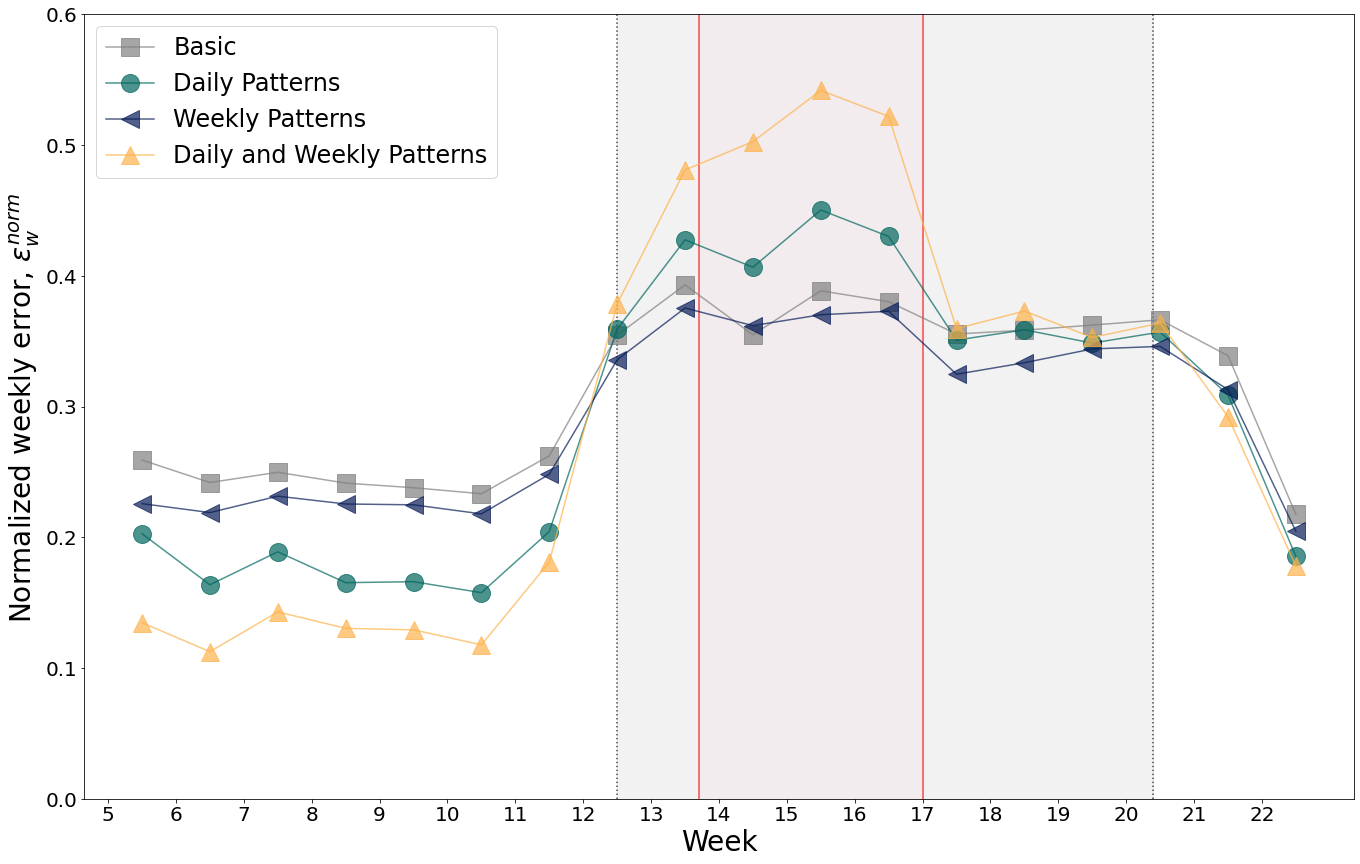

In [80]:
%matplotlib inline
model_names_list = ["Basic", "Daily Patterns", "Weekly Patterns", "Daily and Weekly Patterns"]
color_list = ["gray", "#01665e", "#081d58", "#feb24c"]
marker_list = ['s', 'o',  '<',  '^']
error_books_list = [weekly_error_sum_telia_road_2, weekly_error_sum_telia_road_day_2, weekly_error_sum_telia_road_week_2, weekly_error_sum_telia_road_day_week_2] 
path_for_saving = "/m/cs/scratch/networks/heydars1/mobility-visualizations-finland/plots/comparison_of_weekly_error"
file_save_name = "different_temporal_configs"
#plot_timeline_of_weekly_error(error_books_list, model_names_list, color_list, marker_list, "Normalized weekly error", 0.6, path_for_saving, file_save_name)
#plot_timeline_of_weekly_error(error_books_list, model_names_list, color_list, marker_list, "Normalized weekly error", 0.6)
plot_timeline_of_weekly_error(error_books_list, model_names_list, color_list, marker_list, 'Normalized weekly error, $\epsilon_{w}^{norm}$ ', 0.6, path_for_saving, file_save_name)

In [81]:
weekly_error_sum_telia_road_2

{19: 0.36234961511138836,
 21: 0.3389466247936657,
 8: 0.2414779530954436,
 7: 0.2497743414158553,
 6: 0.24193249003153147,
 12: 0.3546464148337262,
 16: 0.3802249770424724,
 10: 0.2333480756712149,
 22: 0.21760286237755203,
 17: 0.3555488547158135,
 14: 0.35495432322796194,
 11: 0.26233769960683806,
 5: 0.2591134339627399,
 18: 0.358449484959997,
 15: 0.38859241073505607,
 20: 0.3663882535851952,
 13: 0.39312808467907484,
 9: 0.23793317771796835}

In [82]:
averages = [np.mean(list(weekly_error_sum_telia_road_2.values())), np.mean(list(weekly_error_sum_telia_road_day_2.values())), np.mean(list(weekly_error_sum_telia_road_week_2.values())), np.mean(list(weekly_error_sum_telia_road_day_week_2.values()))]
model_names_list = ["Basic", "Daily Patterns", "Weekly Patterns", "Daily and Weekly Patterns"]
print(model_names_list)
print(averages)

['Basic', 'Daily Patterns', 'Weekly Patterns', 'Daily and Weekly Patterns']
[0.3109305043090831, 0.2906816109543928, 0.29305925218767137, 0.2941424743876237]


# How much does using road traffic data decrease the error of the static model?

In [83]:
relative_list = []
for key in weekly_error_sum_road_radiation_12h_2.keys():
    print(key)
    print(weekly_error_sum_road_radiation_12h_2[key]/weekly_error_sum_static_radiation_2[key])
    relative_list.append(weekly_error_sum_road_radiation_12h_2[key]/weekly_error_sum_static_radiation_2[key])
print(np.average(relative_list))

12
0.8232940585683656
9
0.7174991659720336
21
0.8422006942334033
6
0.7639381490982785
7
0.7411087624634635
11
0.7711542165890511
10
0.7244917001563831
13
0.6964277089205281
8
0.7603580134674216
20
0.8193690434568793
19
0.8146679884915701
18
0.8474411831847936
22
0.7571922927440996
17
0.817024060271962
16
0.70134898890871
5
0.7775366257751289
15
0.609236118881599
14
0.6234501996536643
0.755985498379852


In [84]:
relative_list = []
for key in weekly_error_sum_road_gravity_12h_2.keys():
    print(key)
    print(weekly_error_sum_road_gravity_12h_2[key]/weekly_error_sum_static_gravity_2[key])
    relative_list.append(weekly_error_sum_road_gravity_12h_2[key]/weekly_error_sum_static_gravity_2[key])
print(np.average(relative_list))

12
0.7541027942838824
9
0.6565329216888688
21
0.6883246629159215
6
0.6451775993465544
7
0.6757024825361294
11
0.6777625196054936
10
0.6311255236751255
13
0.7306575204023302
8
0.6521962966056654
20
0.6897411690597852
19
0.6622332132457696
18
0.7237089012954265
22
0.5869156740036983
17
0.6853077240380259
16
0.696639907910599
5
0.6863328567083662
15
0.6209900729014078
14
0.6294943207313546
0.6718303422752447


In [84]:
weekly_error_sum_google_gravity_2

{12: 0.7190242353887902,
 14: 0.7254917051345929,
 17: 0.7453232760790666,
 10: 0.7205699912308697,
 18: 0.7497845772291296,
 21: 0.7537690501779183,
 16: 0.7239376019602927,
 13: 0.7306794516714693,
 15: 0.7118812566560931,
 9: 0.7245747674008606,
 8: 0.7295302947438386,
 20: 0.7391777129919432,
 19: 0.7444237978173315,
 22: 0.5550413973989466,
 11: 0.7183134905007461}

In [85]:
weekly_error_sum_google_radiation_2

{12: 0.5257380889390045,
 14: 0.6571842258562539,
 17: 0.5703091807805009,
 10: 0.5038007988787084,
 18: 0.5688746383504893,
 21: 0.5830234999017389,
 16: 0.5764621685009728,
 13: 0.5824966844333831,
 15: 0.6454414950742012,
 9: 0.5155485654277424,
 8: 0.5124305261285337,
 20: 0.5582680320952148,
 19: 0.5642782546165794,
 22: 0.4211869673477524,
 11: 0.5028300478688803}

In [86]:
weekly_error_sum_static_gravity_2

{17: 0.6442633633903645,
 12: 0.6372962528721258,
 14: 0.598520852646069,
 11: 0.7336373166291863,
 10: 0.7630836772012264,
 18: 0.6643658377118818,
 21: 0.7252113552159758,
 16: 0.6010035297983609,
 13: 0.6119278435235743,
 15: 0.6057630576609974,
 9: 0.7753934402925972,
 8: 0.7776888838844651,
 20: 0.6627226921829843,
 5: 0.7552360246599642,
 19: 0.672057613631811,
 22: 0.543237716516589,
 6: 0.7530062574184748,
 7: 0.6309619515421261}

## Normalized

<Figure size 432x288 with 0 Axes>

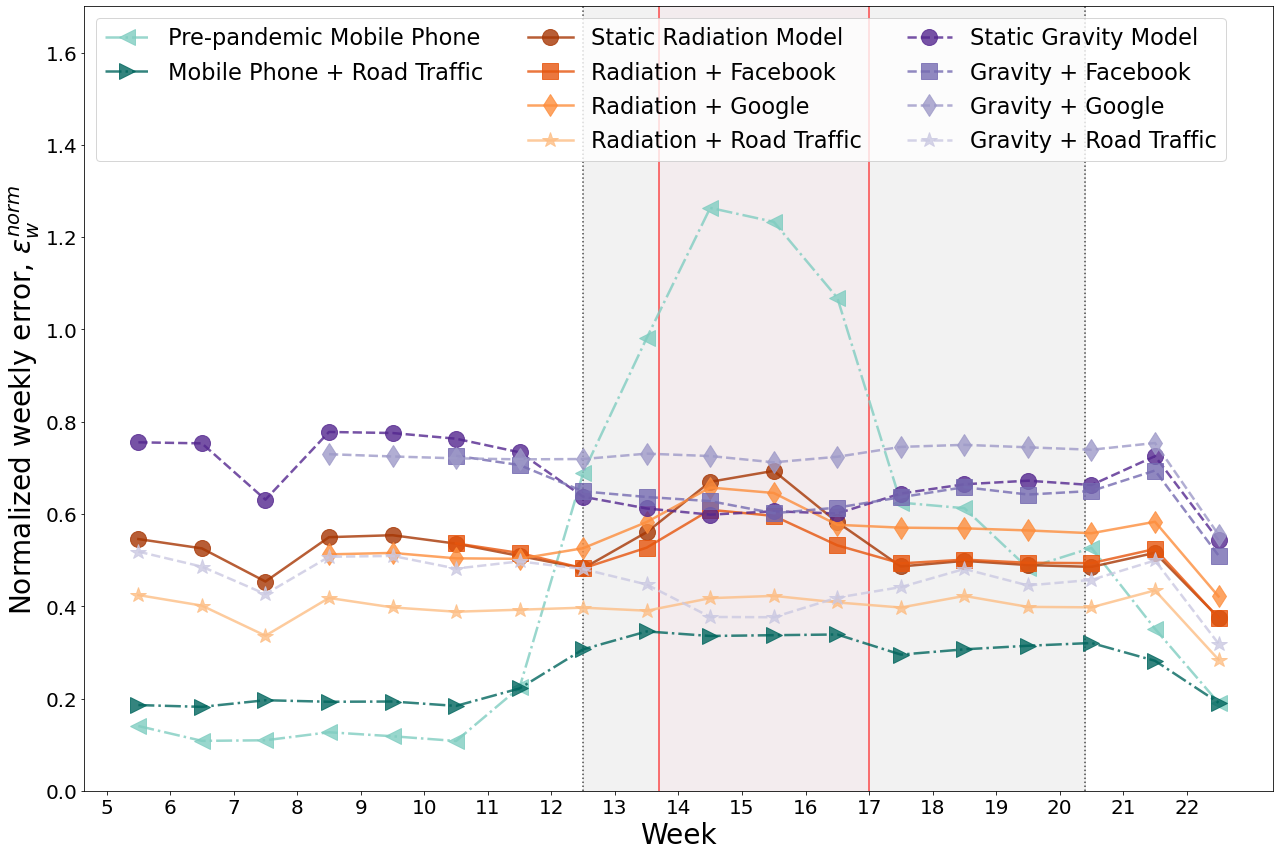

In [102]:
model_names_list = ["Pre-pandemic Mobile Phone", "Mobile Phone + Road Traffic", " ", " ",
                    "Static Radiation Model", "Radiation + Facebook",  "Radiation + Google", "Radiation + Road Traffic",
                    "Static Gravity Model", "Gravity + Facebook",  "Gravity + Google", "Gravity + Road Traffic"]
marker_list = ['<', '>', ".", ".", 'o', 's', 'd', '*', 'o', 's', 'd', '*']
opacity_list = [0.8, 0.8, 0, 0, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8]

color_list = ["#80cdc1", "#01665e", "black", "black", "#a63603", "#e6550d", "#fd8d3c", "#fdbe85", "#54278f", "#756bb1", "#9e9ac8", "#cbc9e2"]
normalized_error_books_list = [weekly_error_sum_telia_baseline_2_12h, weekly_error_sum_telia_road_week_12h_2, weekly_error_sum_telia_baseline_2_12h, weekly_error_sum_telia_baseline_2_12h,
                               weekly_error_sum_static_radiation_2, weekly_error_sum_fb_radiation_2, weekly_error_sum_google_radiation_2, weekly_error_sum_road_radiation_12h_2,
                               weekly_error_sum_static_gravity_2, weekly_error_sum_fb_gravity_2, weekly_error_sum_google_gravity_2, weekly_error_sum_road_gravity_12h_2]
linestyle_list = ["dashdot", "dashdot", "solid", "solid", "solid", "solid", "solid", "solid", "dashed", "dashed", "dashed", "dashed"]


path_for_saving = "/m/cs/scratch/networks/heydars1/mobility-visualizations-finland/plots/comparison_of_weekly_error"
file_save_name = "normalized_all_models_interventions_highlighted"

plot_timeline_of_weekly_errors_and_interventions(normalized_error_books_list, model_names_list, color_list, marker_list, linestyle_list, opacity_list, "Normalized weekly error, $\epsilon_{w}^{norm}$", 1.7, path_for_saving, file_save_name)


<Figure size 432x288 with 0 Axes>

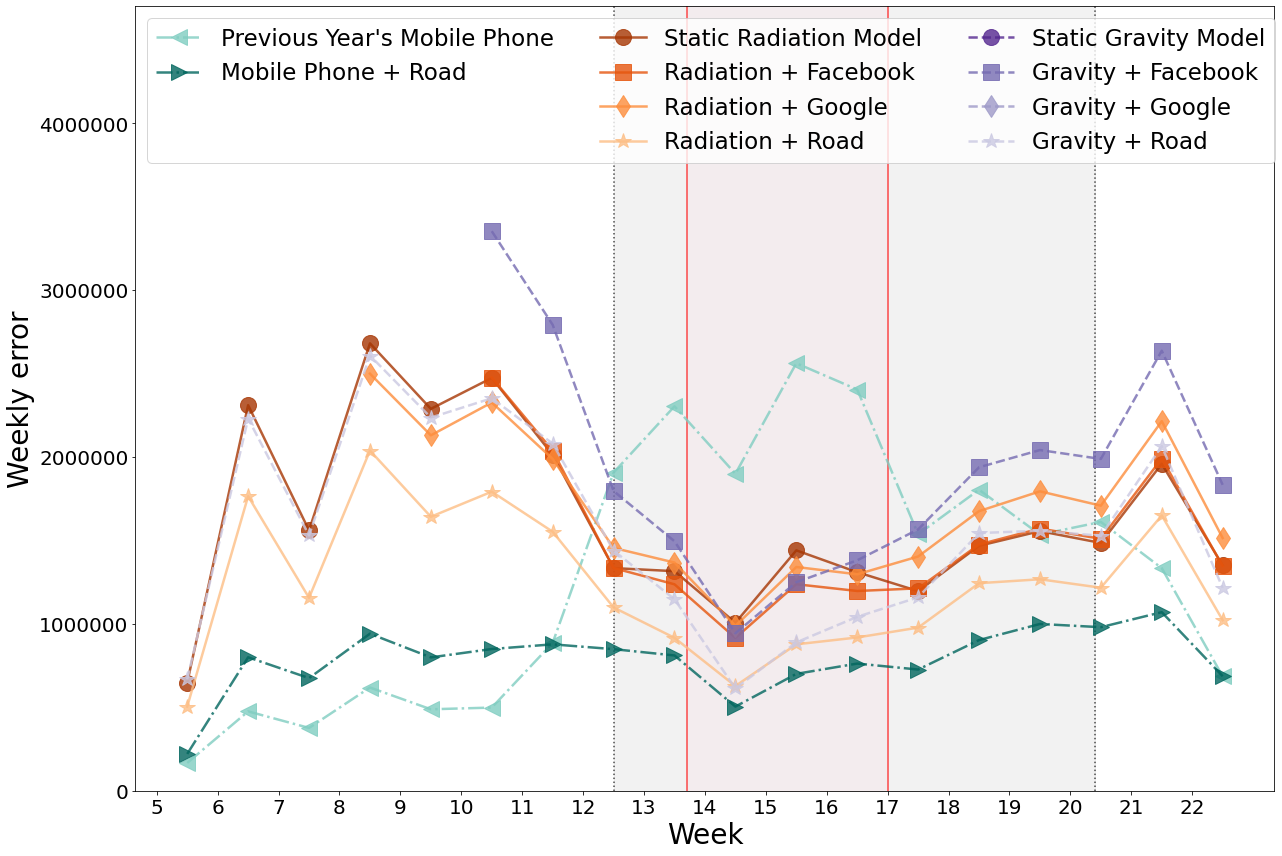

In [132]:
model_names_list = ["Previous Year's Mobile Phone", "Mobile Phone + Road", " ", " ",
                    "Static Radiation Model", "Radiation + Facebook",  "Radiation + Google", "Radiation + Road",
                    "Static Gravity Model", "Gravity + Facebook",  "Gravity + Google", "Gravity + Road"]
marker_list = ['<', '>', ".", ".", 'o', 's', 'd', '*', 'o', 's', 'd', '*']
opacity_list = [0.8, 0.8, 0, 0, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8]

color_list = ["#80cdc1", "#01665e", "black", "black", "#a63603", "#e6550d", "#fd8d3c", "#fdbe85", "#54278f", "#756bb1", "#9e9ac8", "#cbc9e2"]

unnormalized_error_books_list = [weekly_error_sum_telia_baseline_12h, weekly_error_sum_telia_road_week_12h, weekly_error_sum_telia_baseline_12h, weekly_error_sum_telia_baseline_12h,
                                 weekly_error_sum_static_radiation, weekly_error_sum_fb_radiation, weekly_error_sum_google_radiation, weekly_error_sum_road_radiation_12h,
                                 weekly_error_sum_static_gravity, weekly_error_sum_fb_gravity, weekly_error_sum_google_gravity, weekly_error_sum_road_gravity_12h]

linestyle_list = ["dashdot", "dashdot", "solid", "solid", "solid", "solid", "solid", "solid", "dashed", "dashed", "dashed", "dashed"]


path_for_saving = "/m/cs/scratch/networks/heydars1/mobility-visualizations-finland/plots/comparison_of_weekly_error"
file_save_name = "unnormalized_all_models_interventions_highited"
#plot_timeline_of_weekly_errors_and_interventions_unnormalized(unnormalized_error_books_list, model_names_list, color_list, marker_list, linestyle_list, opacity_list, "Normalized weekly error")


plot_timeline_of_weekly_errors_and_interventions_unnormalized(unnormalized_error_books_list, model_names_list, color_list, marker_list, linestyle_list, opacity_list, "Weekly error", 4700000, path_for_saving, file_save_name)


In [80]:
relative_list = []
for key in weekly_error_sum_road_gravity_12h_2.keys():
    print(key)
    print(weekly_error_sum_road_gravity_12h_2[key]/weekly_error_sum_static_gravity_2[key])
    relative_list.append(weekly_error_sum_road_gravity_12h_2[key]/weekly_error_sum_static_gravity_2[key])
print(np.average(relative_list))

6
0.7147151373107051
9
0.7056435786844918
19
0.7712467165923389
18
0.8120529184203975
11
0.751295765801664
16
0.8409104196059428
13
0.878800707462795
10
0.6855266710571873
20
0.8094324216461981
12
0.8714212846943058
15
0.7628842694493424
17
0.79928424380491
8
0.7102986098438504
21
0.7509143947089174
22
0.6669662186755393
14
0.7580604684065214
5
0.7372161278310555
7
0.7152482428438627
0.7634398998244459


# static radiation vs radiation + road

In [81]:
median_od_normalized_absolute_error_road_rad = {od:np.median(nma_error_separated_by_od_road_rad[od]) for od in nma_error_separated_by_od_road_rad.keys()}

median_od_normalized_absolute_error_static_rad = {od:np.median(nma_error_separated_by_od_static_rad[od]) for od in nma_error_separated_by_od_static_rad.keys()}

NameError: name 'nma_error_separated_by_od_road_rad' is not defined

In [ ]:
relative_performance = {key: median_od_normalized_absolute_error_static_rad[key]/median_od_normalized_absolute_error_road_rad[key] for (key,value) in median_od_normalized_absolute_error_road_rad.items()}
title_string = " "
plot_origin_destination_error_matrix(relative_performance, title_string, hcd_orderd, False, None)